# Other vegetation sub-model - Notebook 2

* **Products used:** 
[cgls_landcover](https://explorer.digitalearth.africa/products/cgls_landcover)

## Background

This notebook calculates and stores the second sub-model in the elephant Habitat Suitability Model; the other vegetation sub-model. It has the data layers and weightings listed in the table below. 

Data layer | Layer weighting |
-----------: | -----------: |
Shrubs & herbaceous vegetation (CGLS 20 & 30) | 33.3% | 
Bare ground (CGLS 60) | 33.3% |
Herbaceous wetland (CGLS 90) | 33.3% |


The notebook executes the following steps:

   1. Load landcover CGLS data and select the relevant vegetation layers.
   2. Within the area of interest, calculate distance to vegetation layers quantified as euclidean distance in metres.
   3. Standardise the euclidean distance measure so it ranges between 0 and 1.
   4. Use a weighted linear combination approach to estimate habitat suitability from a vegetation cover perspective.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr
from deafrica_tools.plotting import plot_lulc

try:
      import xrspatial
except:
      !pip install xrspatial
    
from xrspatial import proximity

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='Elephant-HSM-otherveg')

## Load CGLS landcover

Spatial parameters must be the same as other notebooks.

In [3]:
#create reusable datacube query object
%store -r query

ds_cgls = dc.load(product='cgls_landcover', **query).squeeze()

ds_cgls

<xarray.Dataset>
Dimensions:         (y: 3618, x: 2895)
Coordinates:
    time            datetime64[ns] 2019-07-02T11:59:59.500000
  * y               (y) float64 -2.047e+06 -2.048e+06 ... -2.770e+06 -2.771e+06
  * x               (x) float64 1.416e+06 1.417e+06 ... 1.995e+06 1.995e+06
    spatial_ref     int32 6933
Data variables:
    classification  (y, x) uint8 126 126 126 20 126 20 126 ... 20 20 20 20 20 20
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

# Other vegetation layers

The table at the beginning of this notebook shows that there are three 'other vegetation' layers we need to include in the sub-model. The plot below indicates that the 'shrubs' landcover class dominates the region.

## Visualise location of other vegetation

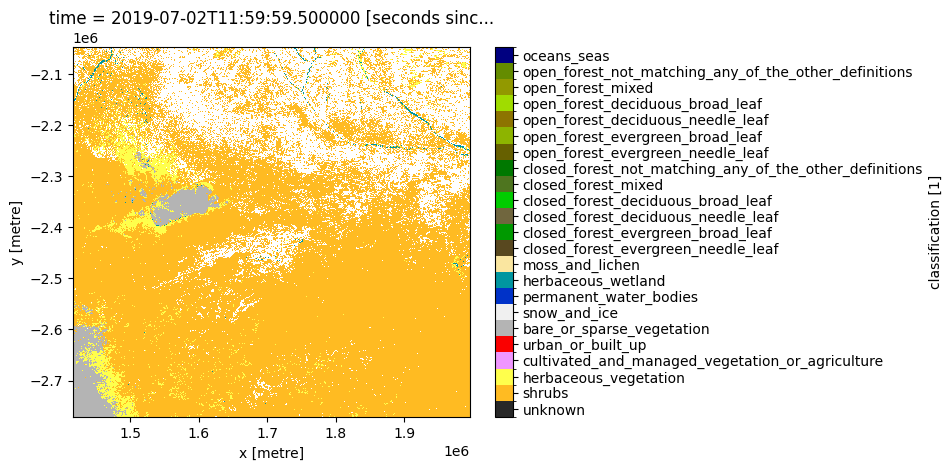

In [4]:
plot_lulc(ds_cgls.where((ds_cgls==20) | (ds_cgls==30)| (ds_cgls==60)| (ds_cgls==90))['classification'], product="CGLS", legend=True)

## Shrubs & herbaceous vegetation

This is the first 'other vegetation' layer in the sub-model. As it is the most dominant class in the default area, the proximity plot is dominated by values close to 1.

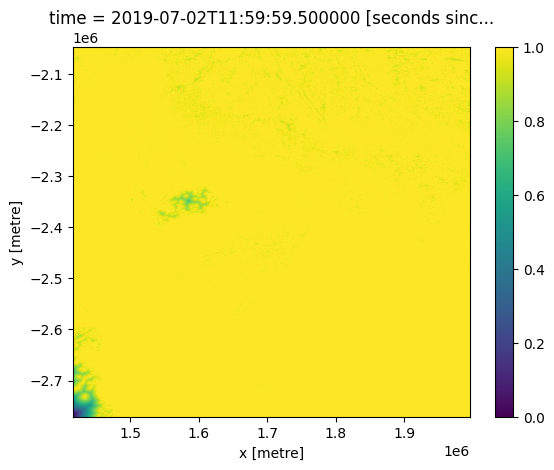

In [5]:
cgls_shv = ds_cgls.where((ds_cgls==20) | (ds_cgls==30))

proximity_shv = proximity(cgls_shv.classification, distance_metric = 'EUCLIDEAN')

shv_proximity_std = 1 - (proximity_shv/np.max(proximity_shv))
shv_proximity_std = shv_proximity_std.fillna(0)
shv_proximity_std.plot()

# Bare ground

The process is repeated for 'bare ground', for which there are some areas in the default area of interest.

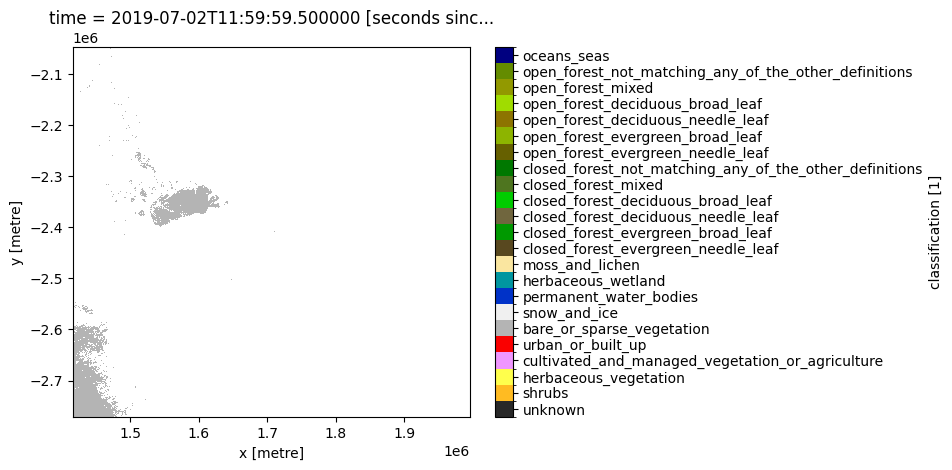

In [6]:
plot_lulc(ds_cgls.where(ds_cgls==60)['classification'], product="CGLS", legend=True)

### Reversing direction of euclidean distance layer

'Bare ground' is considered an undesirable land cover class for elephant habitat as there is no food or water and exposes elephants to the weather, so the direction of the distance layer is reversed relative to preferable features, such as forests or shrubs. That means that areas with bare ground will have `0` values, while areas furthest from bare ground will have values close to `1`. I.e. the further from bare ground an elephant is, the better the habitat suitability is for them.

This is executed by omitting the `1-` in the calculation of `bg_proximity_std` below.

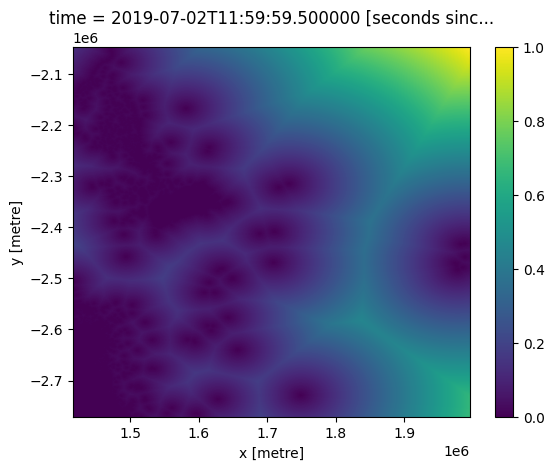

In [7]:
cgls_bg = ds_cgls.where(ds_cgls==60)

bg_proximity = proximity(cgls_bg.classification, distance_metric='EUCLIDEAN')

bg_proximity_std = bg_proximity/np.max(bg_proximity)

bg_proximity_std = bg_proximity_std.fillna(0)
bg_proximity_std.plot()

## Herbaceous wetland

The third layer in the sub-model is 'herbaceous wetland'.

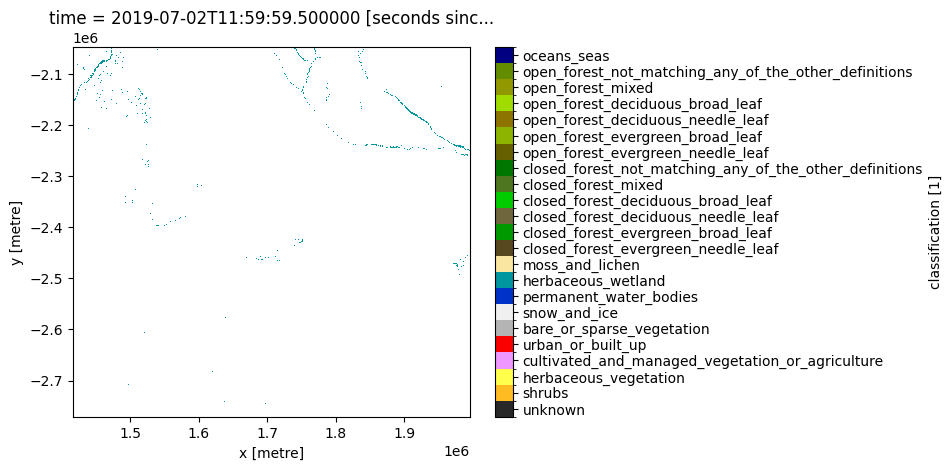

In [8]:
plot_lulc(ds_cgls.where(ds_cgls==90)['classification'], product="CGLS", legend=True)

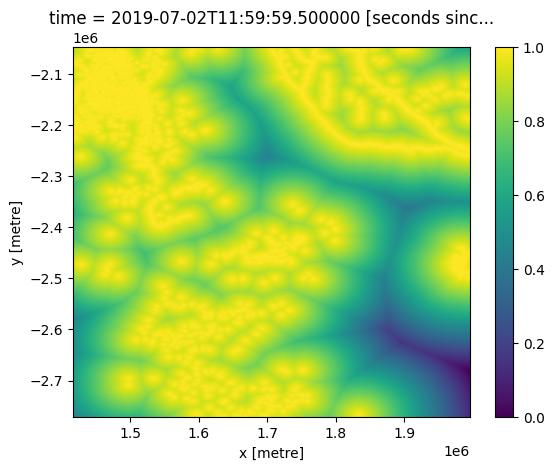

In [9]:
cgls_hw = ds_cgls.where(ds_cgls==90)

hw_proximity = proximity(cgls_hw.classification, distance_metric = 'EUCLIDEAN')

hw_proximity_std = 1 - (hw_proximity/np.max(hw_proximity))

hw_proximity_std = hw_proximity_std.fillna(0)
hw_proximity_std.plot()

# Weighted Linear Combination

Each of the three layers are combined using Weighted Linear Combination.

## Weights

The table at the beginning of the notebook shows that in this sub-model, each layer is given an equal weighting of 33.33%.

In [10]:
weight = 0.3333

Similar to the previous forests notebook, the Weighted Linear Combination calculation is performed by multiplying each 'other vegetation' layer by the weight and adding the results.

We can see that the sub-model generally reflects the distribution of other vegetation in the area of interest, with bare ground penalised.

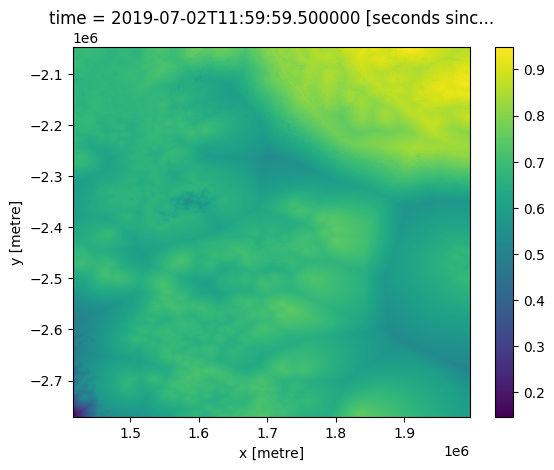

In [11]:
otherveg_model=(shv_proximity_std*weight)+(
    bg_proximity_std*weight)+(
    hw_proximity_std*weight)

otherveg_model.plot()

## Save to outputs

Finally, the other vegetation sub-model is saved to the outputs folder so we can bring it in when we calculate the final habitat suitability model.

In [12]:
otherveg_model = otherveg_model.drop('time', dim=None)
otherveg_model.to_netcdf('outputs/otherveg_sm.nc')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [13]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [14]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-17'